# Google app store EDA & Text mining

## First, let's do the data cleaning

In [1]:
#import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import font_manager as fm
import matplotlib as mpl 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import requests, re
import nltk

import os
from matplotlib import rcParams

#load data
data=pd.read_csv('googleplaystore.csv')
review=pd.read_csv('googleplaystore_user_reviews.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [2]:
data['Rating'].unique()

array([ 4.1,  3.9,  4.7,  4.5,  4.3,  4.4,  3.8,  4.2,  4.6,  3.2,  4. ,
        nan,  4.8,  4.9,  3.6,  3.7,  3.3,  3.4,  3.5,  3.1,  5. ,  2.6,
        3. ,  1.9,  2.5,  2.8,  2.7,  1. ,  2.9,  2.3,  2.2,  1.7,  2. ,
        1.8,  2.4,  1.6,  2.1,  1.4,  1.5,  1.2, 19. ])

In [3]:
#There are some duplicates in the data
data[data['App']=='Subway Surfers']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1654,Subway Surfers,GAME,4.5,27722264,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
1700,Subway Surfers,GAME,4.5,27723193,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
1750,Subway Surfers,GAME,4.5,27724094,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
1872,Subway Surfers,GAME,4.5,27725352,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
1917,Subway Surfers,GAME,4.5,27725352,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up
3896,Subway Surfers,GAME,4.5,27711703,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up


In [4]:
#Drop all rows with same app name
data = data.drop_duplicates(subset=['App'],keep='first')

In [5]:
data['Rating'].unique()

array([ 4.1,  3.9,  4.7,  4.5,  4.3,  4.4,  3.8,  4.2,  4.6,  3.2,  4. ,
        nan,  4.8,  4.9,  3.6,  3.7,  3.3,  3.4,  3.5,  3.1,  5. ,  2.6,
        3. ,  1.9,  2.5,  2.8,  2.7,  1. ,  2.9,  2.3,  2.2,  1.7,  2. ,
        1.8,  2.4,  1.6,  2.1,  1.4,  1.5,  1.2, 19. ])

In [6]:
data[data['Rating']==19]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [7]:
# Drop row with wrong value
data=data.drop(index=[10472])
# Fill na values with mean value 
data['Rating']=data['Rating'].fillna(round(data['Rating'].mean(),1))
#Change 'Reviews' into integer
data['Reviews']=data['Reviews'].astype(int)
#Convert 'Size' with 'KB' into 'MB' and convert this column into float.
data['Size']=data['Size'].map(lambda x: str(x).replace('Varies with device', 
                                                       'NaN') if 'Varies with device' in str(x) else x)
data['Size']=data['Size'].map(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
data['Size']=data['Size'].map(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
data['Size']=data['Size'].map(lambda x: float(str(x).replace('k', '')) / 1024 if 'k' in str(x) else x)
data['Size']=data['Size'].astype(float)
data=data.rename(columns={'Size':'Size(M)'})
#Modify the 'Android ver' column
data['Android Ver']=data['Android Ver'].map(lambda x: str(x).replace(' and up', 
                                                       '') if ' and up' in str(x) else x)
data['Android Ver']=data['Android Ver'].map(lambda x: str(x).split(' ')[0] if 'Varies with device' not in str(x) else x)
data=data.rename(columns={'Android Ver':'Android Ver(lowest)'})

In [8]:
data['Android Ver(lowest)'].unique()

array(['4.0.3', '4.2', '4.4', '2.3', '3.0', '4.1', '4.0', '2.3.3',
       'Varies with device', '2.2', '5.0', '6.0', '1.6', '1.5', '2.1',
       '7.0', '5.1', '4.3', '2.0', '3.2', '4.4W', '7.1', '8.0', '3.1',
       '2.0.1', 'nan', '1.0'], dtype=object)

In [9]:
data=data.rename(columns={'Android Ver':'Android Ver(minimum)'})
#Delete '+' in the 'install' column and convert into integer
data['Installs']=data['Installs'].map(lambda x: x.rstrip('+').replace(',','')).astype(int)
#Drop null rows whose value for 'Type' column is null
data[data['Type'].isnull().values==True]

,App,Category,Rating,Reviews,Size(M),Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver(lowest)
9148,Command & Conquer: Rivals,FAMILY,4.2,0,NaN,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device


In [10]:
data=data.drop(index=[9148])
#Remove '$' from 'Price' column and convert into float.
data['Price']=data['Price'].str.replace('$','').astype(float)
data=data.rename(columns={'Price':'Price($)'})
#Convert 'Last Updated' column into date format
data['Last Updated']=pd.to_datetime(data['Last Updated'])
data['Content Rating'].value_counts()

Everyone           7903
Teen               1036
Mature 17+          393
Everyone 10+        321
Adults only 18+       3
Unrated               2
Name: Content Rating, dtype: int64

In [11]:
data['Content Rating']=data['Content Rating'].map(lambda x: str(x).replace('Adults only 18+', 
                                                       'Mature 17+') )
data['Content Rating']=data['Content Rating'].map(lambda x: str(x).replace('Unrated', 
                                                       'Everyone') )

In [12]:
data.head()

,App,Category,Rating,Reviews,Size(M),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver(lowest)
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4


## Then let's find something intereting in the data: EDA

### Category

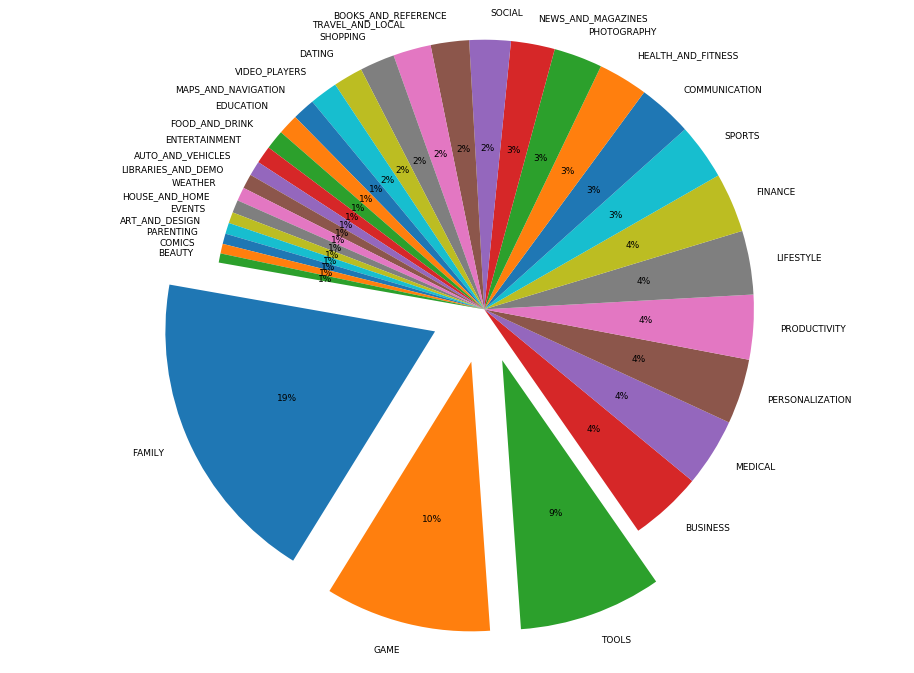

In [13]:
data_category=data['Rating'].groupby(by=data['Category']).describe().sort_values(by='count', ascending=False) #sorted by market share
data_category['Category']=data_category.index
labels = data_category['Category']
sizes = data_category['count']
explode = (0.2,0.2,0.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) 
fig1, ax1 = plt.subplots(figsize=(16,12))
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=170)
ax1.axis('equal')
proptease = fm.FontProperties()
proptease.set_size('9')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)
plt.show()

Text(0.5, 1.0, 'Apps in each category')

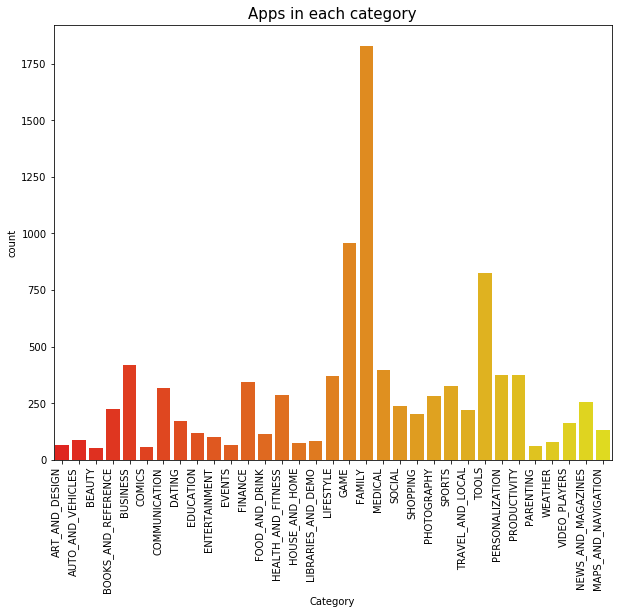

In [14]:
plt.figure(figsize=(10,8))
category_plot = sns.countplot(x="Category",data=data, palette = "autumn")
category_plot.set_xticklabels(category_plot.get_xticklabels(), rotation=90, ha="right")
category_plot 
plt.title('Apps in each category',size = 15)

We can see that "Family", "Game" and "Tools" are the most categories

### Price

Text(0.5, 1.0, 'Number of Free Apps vs Paid Apps')

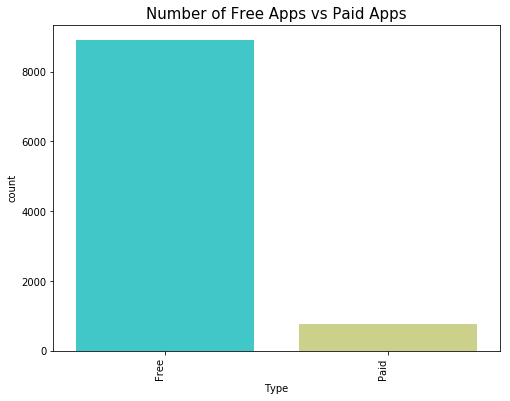

In [15]:
plt.figure(figsize=(8,6))
price_plot = sns.countplot(x="Type", data=data, palette = "rainbow")
price_plot.set_xticklabels(price_plot.get_xticklabels(), rotation=90, ha="right")
price_plot 
plt.title('Number of Free Apps vs Paid Apps',size = 15)

So free apps are much more than paid apps.

Text(0.5, 1.0, 'Number of apps for each price')

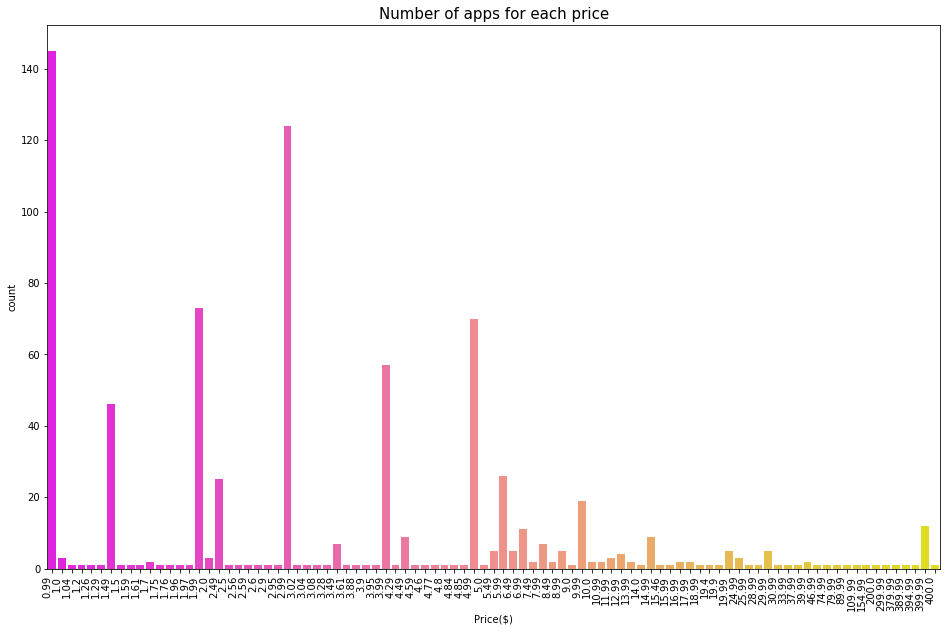

In [16]:
data['Price($)'] = data['Price($)'].apply(lambda x: float(x))
plt.figure(figsize=(16,10))
priced_apps=data[data['Price($)'] != 0.0]
price_plot = sns.countplot(priced_apps['Price($)'], palette = "spring")
price_plot.set_xticklabels(price_plot.get_xticklabels(), rotation=90, ha="right")
price_plot 
plt.title('Number of apps for each price',size = 15)

Here we notciced that there're some very expensive apps. Let's take a look at what's happening for those apps

In [17]:
costlier = data[data["Price($)"]>=100]
costlier

,App,Category,Rating,Reviews,Size(M),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver(lowest)
4197,most expensive app (H),FAMILY,4.3,6,1.500000,100,Paid,399.99,Everyone,Entertainment,2018-07-16,1.0,7.0
4362,💎 I'm rich,LIFESTYLE,3.8,718,26.000000,10000,Paid,399.99,Everyone,Lifestyle,2018-03-11,1.0.0,4.4
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300000,10000,Paid,400.00,Everyone,Lifestyle,2018-05-03,1.0.1,4.1
5351,I am rich,LIFESTYLE,3.8,3547,1.800000,100000,Paid,399.99,Everyone,Lifestyle,2018-01-12,2.0,4.0.3
5354,I am Rich Plus,FAMILY,4.0,856,8.700000,10000,Paid,399.99,Everyone,Entertainment,2018-05-19,3.0,4.4
5355,I am rich VIP,LIFESTYLE,3.8,411,2.600000,10000,Paid,299.99,Everyone,Lifestyle,2018-07-21,1.1.1,4.3
5356,I Am Rich Premium,FINANCE,4.1,1867,4.700000,50000,Paid,399.99,Everyone,Finance,2017-11-12,1.6,4.0
5357,I am extremely Rich,LIFESTYLE,2.9,41,2.900000,1000,Paid,379.99,Everyone,Lifestyle,2018-07-01,1.0,4.0
5358,I am Rich!,FINANCE,3.8,93,22.000000,1000,Paid,399.99,Everyone,Finance,2017-12-11,1.0,4.1
5359,I am rich(premium),FINANCE,3.5,472,0.942383,5000,Paid,399.99,Everyone,Finance,2017-05-01,3.4,4.4


These apps seems like a joke?
We will filter out those apps in the further analysis

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


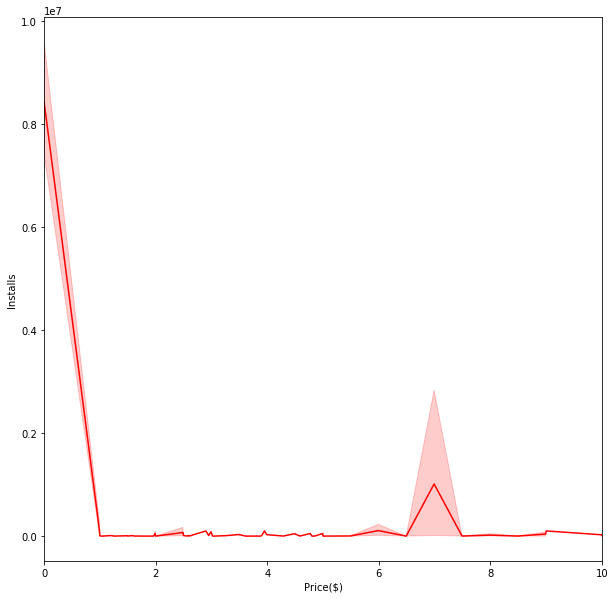

In [18]:
data=data[data['Price($)']<=100]
plt.figure(figsize=(10,10))
price_installs_plot = sns.lineplot(x="Price($)", y="Installs",color='red', data=data)
price_installs_plot.set(xlim=(0, 10))
plt.show()

* Most paid apps are priced 0.99 dollars.
* Paid apps mostly cost 0.99 dollars, 3.02 dollars ,2 dollars ,5 dollars or 4.29 dollars
* If you want to charge your apps, less than 1 dollar is a good idea which will not significantly decrease the installs

#### Is there any difference between free and paid apps?

Text(0.5, 1.0, 'Size Range for free and paid Apps')

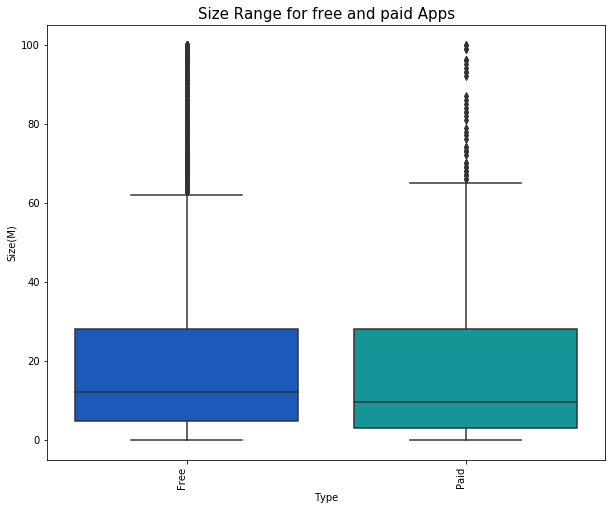

In [19]:
plt.figure(figsize=(10,8))
price_size = sns.boxplot(x="Type",y="Size(M)", data=data, palette = "winter")
price_size.set_xticklabels(price_size.get_xticklabels(), rotation=90, ha="right") 
plt.title('Size Range for free and paid Apps',size = 15)

It seems like both free and paid apps have a size range between 5 and 30 MB.

What about the most installed apps for free and paid apps? Is there any difference?
First let's filter out the most installed apps for free apps.

In [20]:
data.Installs.unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,         50,        100,
              500,         10,          1,          5,          0])

In [21]:
free_df=data[['App','Installs','Category','Content Rating','Price($)','Reviews','Genres']].groupby(['Installs'], sort = True)
free_df=free_df.filter(lambda x: x['Installs'].mean() >= 500000000)
free_df=free_df.sort_values(by=['Installs'])
free_df.head()

,App,Installs,Category,Content Rating,Price($),Reviews,Genres
2550,Snapchat,500000000,SOCIAL,Teen,0.0,17014787,Social
4005,Clean Master- Space Cleaner & Antivirus,500000000,TOOLS,Everyone,0.0,42916526,Tools
3755,Flipboard: News For Our Time,500000000,NEWS_AND_MAGAZINES,Everyone 10+,0.0,1284017,News & Magazines
3739,Twitter,500000000,NEWS_AND_MAGAZINES,Mature 17+,0.0,11667403,News & Magazines
3703,MX Player,500000000,VIDEO_PLAYERS,Everyone,0.0,6474426,Video Players & Editors


Now let's plot the top categories for most installed free apps

Text(0.5, 1.0, 'Top Categories for Free Apps')

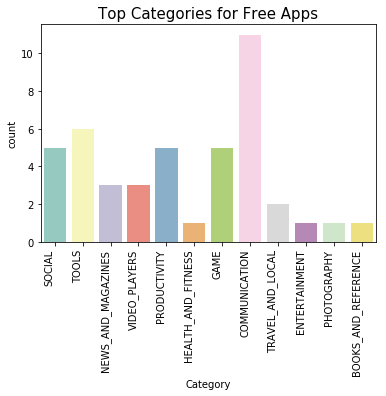

In [22]:
free_categories = sns.countplot(x="Category",data=free_df, palette = "Set3")
free_categories.set_xticklabels(free_categories.get_xticklabels(), rotation=90, ha="right")
plt.title('Top Categories for Free Apps',size = 15)

Also take a look at the genres of the most installed free apps

In [23]:
free_df.groupby('Genres').count()['App']

Genres
Action                      1
Arcade                      1
Books & Reference           1
Casual                      3
Communication              11
Entertainment               1
Health & Fitness            1
News & Magazines            3
Photography                 1
Productivity                5
Social                      5
Tools                       6
Travel & Local              2
Video Players & Editors     3
Name: App, dtype: int64

Do the same things for the paid apps

In [24]:
paiddf=data[['App','Category','Content Rating','Price($)','Reviews']].groupby(['Price($)'], sort = True)
paiddf=paiddf.filter(lambda x: x['Price($)'].mean() != 0)
paiddf=paiddf.sort_values(by=['Price($)'])
paiddf2=data[['App','Installs','Genres']].groupby(['Installs'], sort = True)
paiddf2=paiddf2.filter(lambda x: x['Installs'].mean() >= 1000000)
paiddf2=paiddf2.sort_values(by=['Installs'])
paid_df = pd.merge(paiddf, paiddf2, how='inner', on=['App'])
paid_df

,App,Category,Content Rating,Price($),Reviews,Installs,Genres
0,Stickman Legends: Shadow Wars,GAME,Everyone 10+,0.99,38419,1000000,Action
1,Lost Journey (Dreamsky),GAME,Everyone,0.99,32344,1000000,Adventure
2,Hitman Sniper,GAME,Mature 17+,0.99,408292,10000000,Action
3,Infinity Dungeon VIP,FAMILY,Everyone 10+,0.99,21804,1000000,Role Playing
4,League of Stickman 2018- Ninja Arena PVP(Dream...,GAME,Teen,0.99,32496,1000000,Action
5,Zombie Avengers:(Dreamsky)Stickman War Z,GAME,Teen,0.99,13604,1000000,Action
6,HD Widgets,PERSONALIZATION,Everyone,0.99,58617,1000000,Personalization
7,Fruit Ninja Classic,GAME,Everyone,0.99,85468,1000000,Arcade
8,Cut the Rope GOLD,FAMILY,Everyone,0.99,61264,1000000,Puzzle
9,Where's My Water?,FAMILY,Everyone,1.99,188740,1000000,Puzzle;Brain Games


Text(0.5, 1.0, 'Top Categories for PAID APPS')

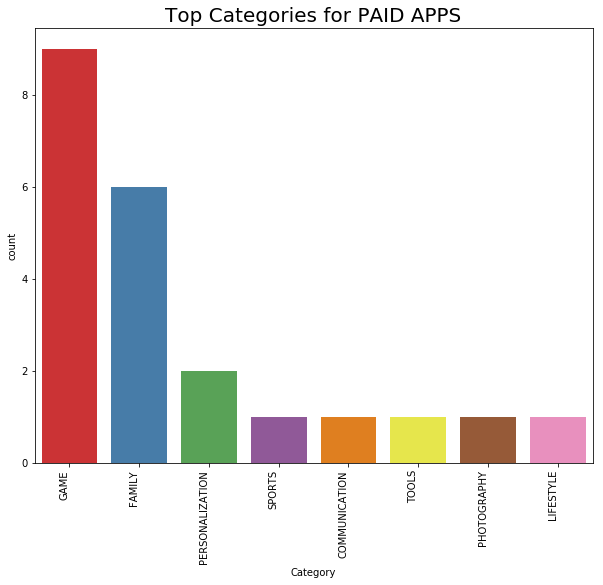

In [25]:
plt.figure(figsize=(10,8))
paid_categories = sns.countplot(x="Category",data=paid_df, palette = "Set1")
paid_categories.set_xticklabels(paid_categories.get_xticklabels(), rotation=90, ha="right")
paid_categories 
plt.title('Top Categories for PAID APPS',size = 20)

In [26]:
paid_df.groupby('Genres').count()['App']

Genres
Action                       7
Adventure                    1
Arcade                       1
Arcade;Action & Adventure    1
Card;Action & Adventure      1
Communication                1
Lifestyle                    1
Personalization              2
Photography                  1
Puzzle                       1
Puzzle;Brain Games           1
Role Playing                 1
Sports                       1
Strategy                     1
Tools                        1
Name: App, dtype: int64

#### Difference between free apps and paid apps:
* People tend to spend their money on games but when it comes to Social Networking and Communication they tend to install the free Apps on the Android Store.
* The 2 most installed Paid Apps are both games
* The majority of most installed free Apps lie in the Communication Category.
* The majority of most installed Paid Apps lie in the Gaming Category.


### Ratings

Text(0.5, 1.0, 'Distribution of Ratings')

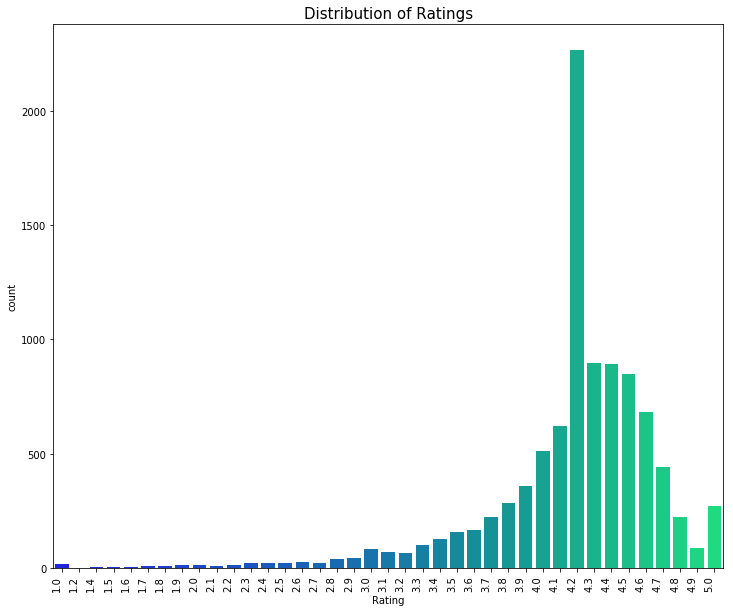

In [27]:
plt.figure(figsize=(12,10))
rating_plot = sns.countplot(x="Rating", data=data, palette = "winter")
rating_plot.set_xticklabels(rating_plot.get_xticklabels(), rotation=90, ha="right")
rating_plot 
plt.title('Distribution of Ratings',size = 15)

Ratings of most of apps range from 3.5 to 5.0. The most common rating is 4.2.

### Installs

Text(0.5, 1.0, 'Installs Distribution')

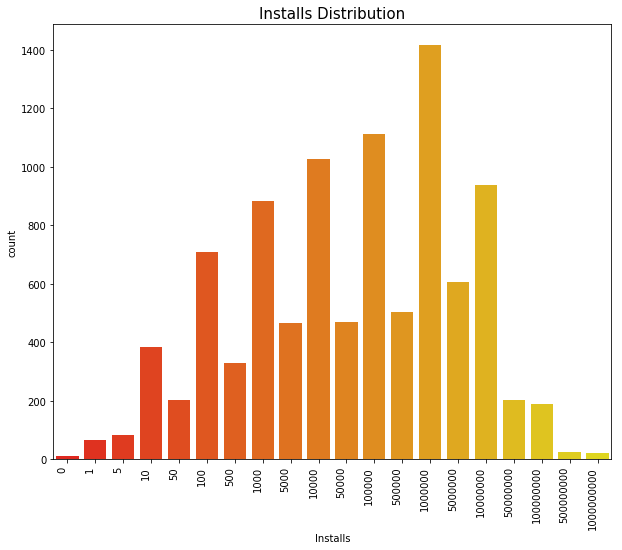

In [28]:
plt.figure(figsize=(10,8))
category_plot = sns.countplot(x="Installs",data=data, palette = "autumn")
category_plot.set_xticklabels(category_plot.get_xticklabels(), rotation=90, ha="right")
category_plot 
plt.title('Installs Distribution',size = 15)

This is quite interesting. The "up and down" maybe indicates that maybe there're overlap between the levels for installs. (ex: "100+" contains  100 <= installs <= 1000, but "500+" only contains installs between 500 and 1000)

Text(0.5, 1.0, 'Installs for Different Content Rating')

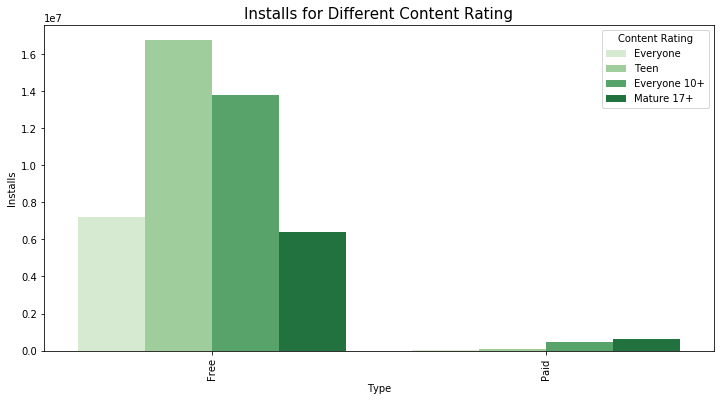

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(x='Type', y='Installs', hue='Content Rating', palette='Greens',ci=None, 
            data=data)
plt.xticks(rotation=90)
plt.title('Installs for Different Content Rating',size = 15)

We can see that the free apps have much more installs, especially with teenagers. And also, we can see that although overall the installs for paid app is much less than the free app, we can still get some conclusion that within paid apps, the Mature adults are more likely to install paid apps.

Back to the category viriable. From the previous chart, we can see that the 'Family','Game' and 'Tools' are the top 3 apps of market share. Generally, we expected that these apps are also the apps with high intalls since they share most of the market. To test our conjecture, we can plot a bar chart of installs for each category.

In [30]:
#sorted by market share
install_df=data['Installs'].groupby(by=data['Category']).describe().sort_values(by='count', ascending=False) 
install_df.head()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
FAMILY,1827.0,2.423600e+06,9.443156e+06,0.0,1000.0,50000.0,1000000.0,1.000000e+08
GAME,959.0,1.447229e+07,5.131609e+07,1.0,100000.0,1000000.0,10000000.0,1.000000e+09
TOOLS,827.0,9.675661e+06,5.456697e+07,1.0,1000.0,50000.0,1000000.0,1.000000e+09
BUSINESS,420.0,1.659916e+06,8.881895e+06,0.0,100.0,1000.0,100000.0,1.000000e+08
MEDICAL,394.0,9.693700e+04,4.091325e+05,1.0,100.0,1000.0,10000.0,5.000000e+06


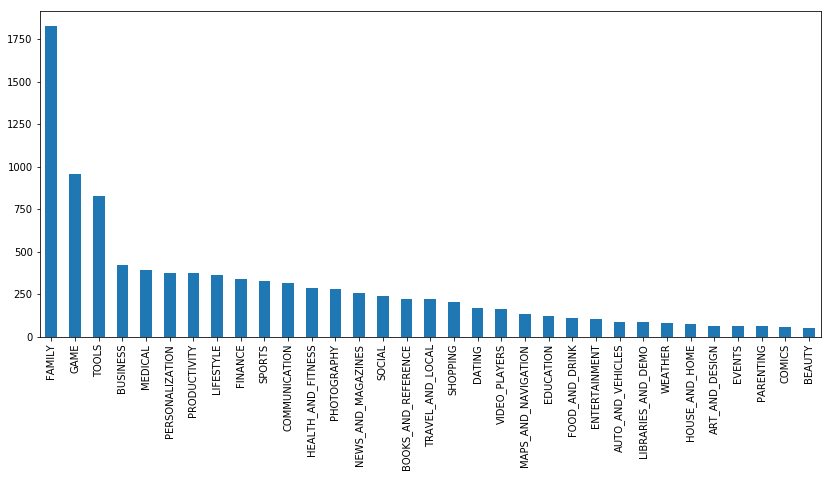

In [31]:
data['Category'].value_counts().plot('bar',figsize=(14,6))

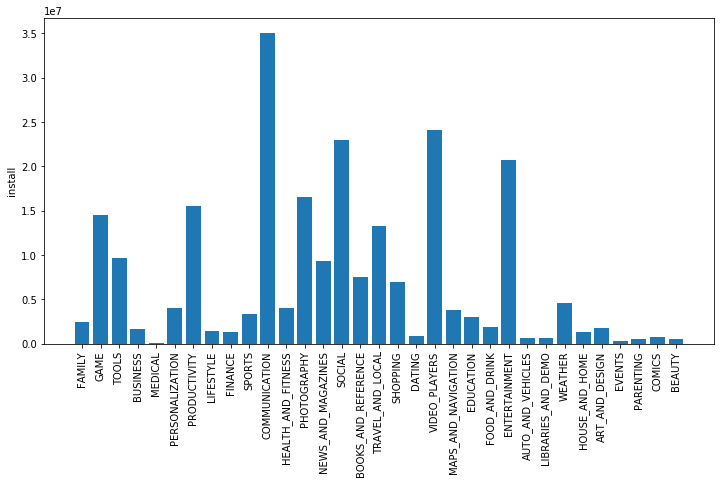

In [32]:
#x-axis is the index of the market share dataframe
plt.figure(figsize=(12, 6))
plt.bar(install_df.index, install_df['mean']) 
plt.xticks(rotation=90)
plt.ylabel('install')
plt.show()

According to the bar chart, we can see that not all high-market share apps are popular among people. There are a lot of family apps but not too many people download them. Athough there are not as many apps as family ,people are more likely to use communication apps rather than high-market share apps.

Then, we try to explore the relation between installs and ratings, which are quite important to judge whether an app is successful or not.

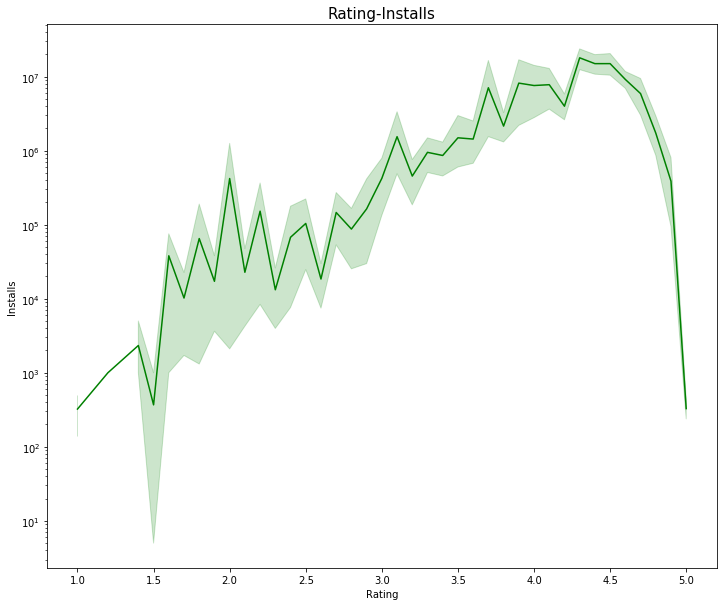

In [33]:
plt.figure(figsize=(12,10))
rate_install_plot= sns.lineplot(x="Rating", y="Installs",color='green', data=data) 
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Installs')
plt.title('Rating-Installs',size = 15)
plt.show()

It seems that the most apps' Rating  ranges from 2.8 to 4.8 is desirable. But over 4.8 the Installations drop significantly. Maybe it is because for an apps who has milliongs of users, there is no way to have 100% likes. But an app with only a few users, is quite possible to have zero dislikes. That is what exactly happens with such high Ratings.



### Analysis of Top apps

The criteria I have selected are:

* High rating
* Large number of installs

In [55]:
newdf_rate=data[['App','Rating','Category','Content Rating','Price($)','Type','Size(M)']].groupby(['Rating'], sort = True)
newdf_rate=newdf_rate.filter(lambda x: x['Rating'].mean() >= 4.5)
newdf_rate=newdf_rate.sort_values(by=['Rating'])
newdf_installs=data[['App','Installs']].groupby(['Installs'], sort = True)
newdf_installs=newdf_installs.filter(lambda x: x['Installs'].mean() >= 10000000)
newdf_installs=newdf_installs.sort_values(by=['Installs'])
top = pd.merge(newdf_installs, newdf_rate, how='inner', on=['App'])
print('Total number of Top apps is:' + str(len(top)))
top.head()

Total number of Top apps is:457


,App,Installs,Rating,Category,Content Rating,Price($),Type,Size(M)
0,"Pulse Nabd - World News, Urgent",10000000,4.5,NEWS_AND_MAGAZINES,Everyone,0.0,Free,12.0
1,Pocket,10000000,4.5,NEWS_AND_MAGAZINES,Everyone,0.0,Free,12.0
2,Build a Bridge!,10000000,4.6,FAMILY,Everyone,0.0,Free,74.0
3,Block City Wars + skins export,10000000,4.5,FAMILY,Teen,0.0,Free,28.0
4,FRONTLINE COMMANDO: D-DAY,10000000,4.5,GAME,Mature 17+,0.0,Free,14.0


Text(0.5, 1.0, 'Size Range for free and paid Apps')

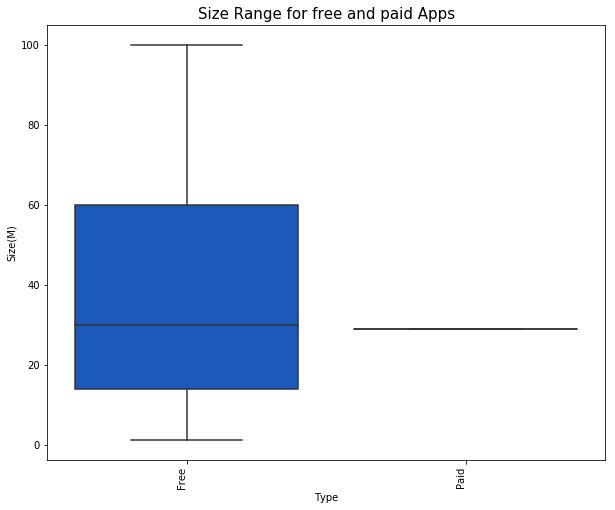

In [36]:
plt.figure(figsize=(10,8))
top_size = sns.boxplot(x="Type",y="Size(M)", data=top, palette = "winter")
top_size.set_xticklabels(top_size.get_xticklabels(), rotation=90, ha="right") 
plt.title('Size Range for free and paid Apps',size = 15)

We can see that among top apps, few are paid apps.

Text(0.5, 1.0, 'Categories among top apps')

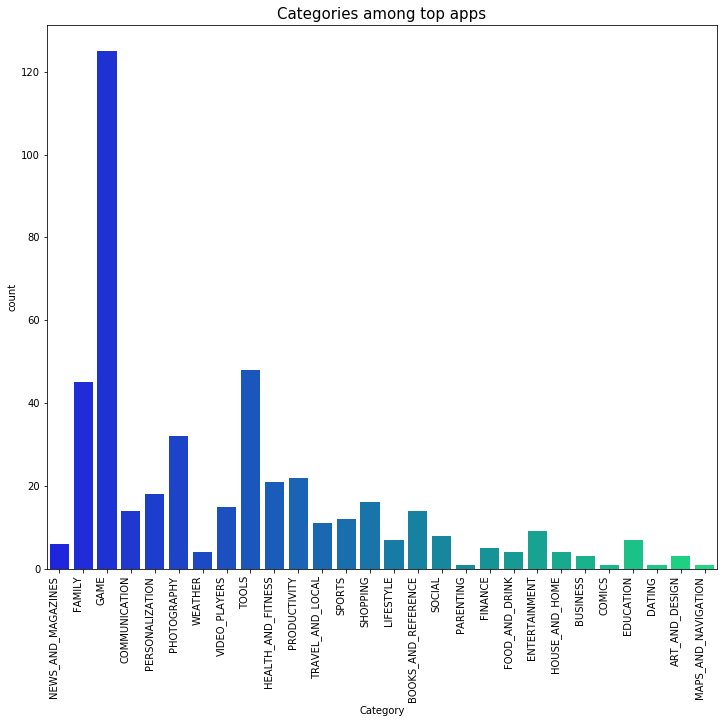

In [37]:
plt.figure(figsize=(12,10))
topcategory_plot = sns.countplot(x="Category", data=top, palette = "winter")
topcategory_plot.set_xticklabels(topcategory_plot.get_xticklabels(), rotation=90, ha="right")
topcategory_plot 
plt.title('Categories among top apps',size = 15)

Game apps still dominate the top apps, and “Photography" apps have been found to be doing well, although the total number of "Photography" apps is not as much as "Game", "Family" and "Tools" apps.

## Text data: Review dataset

### Data processing

We also did some work for our second dataset, which contains some texts. We firstly merged this two datasets by names of the app, and then we selected rows with positive reviews to generate the most often words appeared in the review texts for different categoris so that we can give some suggestions to the software developers what the users care about that can lead to a positive evaluation for the app. More details are included in the code.

In this part, we concentrate more on three categories with large amount of reviews: HEALTH_AND_FITNESS, GAME, TOOLS.

In [38]:
import string, itertools
import re
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [39]:
review=pd.read_csv('googleplaystore_user_reviews.csv')

In [40]:
review.dropna(axis=0, how='any', inplace=True)
review.reset_index(drop=True,inplace=True)

In [41]:
#Merge data and review by same app name
a=pd.merge(data, review, how='inner', on='App', left_on=None, right_on=None,
      left_index=False, right_index=False, sort=True,
      suffixes=('_x', '_y'), copy=True, indicator=False)

In [42]:
review=a.loc[:, ['App', 'Category','Translated_Review','Sentiment','Sentiment_Polarity','Sentiment_Subjectivity']]

In [43]:
#drop rows with na and reset the index
review.dropna(axis=0, how='any', inplace=True)
review=review.drop_duplicates(subset=['Translated_Review'],keep='first')
review.reset_index(drop=True,inplace=True)

Is average rating positive related to average sentiment polarity?

Does the the category with higher rating also have higher average sentiment polarity?

Text(0.5, 1.0, 'Average Sentiment Polarity of Each Category')

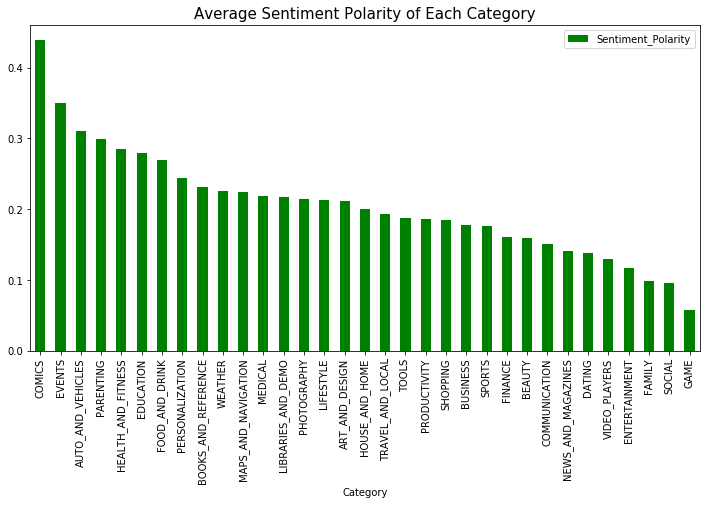

In [44]:
#Calculate the Average Sentiment Polarity of Each Category
p_mean=review.groupby(review['Category'])['Sentiment_Polarity'].mean()
p_mean=p_mean.sort_values(ascending=False)
p_mean=pd.DataFrame(p_mean)
p_mean.plot(kind='bar',figsize=(12,6),color='Green')
plt.title('Average Sentiment Polarity of Each Category',size=15)

Text(0.5, 1.0, 'Average Rating of Each Category')

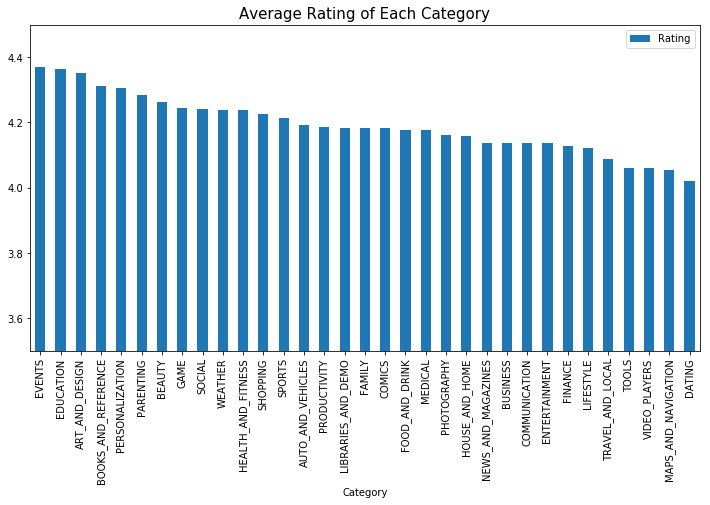

In [45]:
#Calculate the Average Rating of Each Category
r_mean=data.groupby(data['Category'])['Rating'].mean()
r_mean=r_mean.sort_values(ascending=False)
r_mean=pd.DataFrame(r_mean)
r_mean.plot(kind='bar',figsize=(12,6),ylim=(3.5,4.5))
plt.title('Average Rating of Each Category',size=15)

Sentiment polarity is a way to see how positive or negative one review is. -1 means the most negative and 1 means the most positive. The range is from -1 to 1.

From two graphs above, we can see most categories follow the trend: higher rating, higher sentiment polarity. Although the average ratings among categories do not differ a lot, when we turn to the average sentiment polarity, we can see that it differs a lot among categories.

Also there is one interesting thing about GAME: the average rating for GAME is high but the average polarity is the least which means customers are not satisfied with GAME apps although they give GAME apps high rating. We guess that some games may give users some benefits or bonus in the game if users can give a 5-star rating even if customers are not satisfied with this game.

Next, we want to explore what aspects customers care when writing new reviews, especially for HEALTH_AND_FITNESS, GAME, TOOLS apps.

In [46]:
review['Translated_Review']=review['Translated_Review'].map(lambda x : x.lower())

In [47]:
lmtzr = WordNetLemmatizer()
# Create a stop wprd list especially for app reviews
appstop=['ca','better','even','make','app','great','like','love','good','really','would','also','many','much','get','please','add','help','helpful','feel','nice','feeling','phone','excellent','best','work','time','day','need','phone','game','play','want','thing']
#define a function to extract all the words among all the reviews of one category apps
def extract_words(category):
    review_part=review[review['Category']==category]
    words=[]
    ll=review_part['Translated_Review'].map(lambda x : words.extend(word_tokenize(x)))
    words=[word for word in words if not any([x in word for x in string.punctuation])]
    words = [word for word in words if word not in stopwords.words('english')]
    words = [word for word in words if word not in appstop]
    words = [lmtzr.lemmatize(word) for word in words]
    return words

In [48]:
def word_plot(category):
    outwords=extract_words(category)
    wc = WordCloud(background_color='white').generate(' '.join(outwords))
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wc)

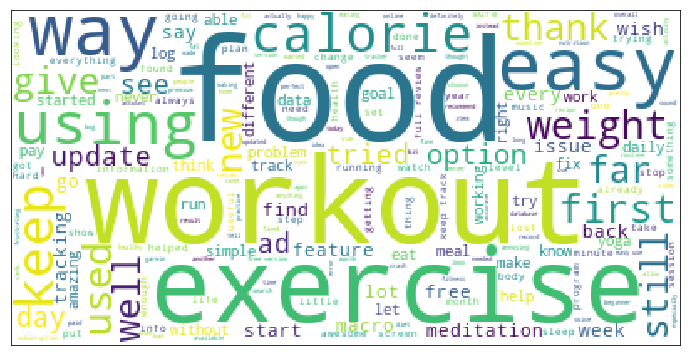

In [49]:
word_plot('HEALTH_AND_FITNESS')

For HEALTH_AND_FITNESS apps, customers'reviews concentrate more on food, exercise, easy, calories.

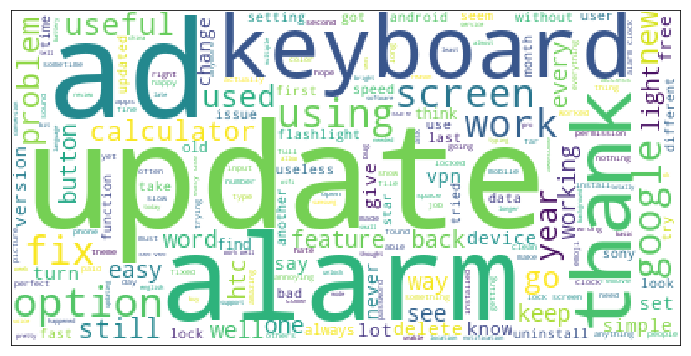

In [50]:
word_plot('TOOLS')

In [51]:
tools_review=review[review['Category']=='TOOLS']
alarm_review=tools_review[tools_review['Translated_Review'].map(lambda x: 'alarm' in x)]
alarm_review.head(10)

,App,Category,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
2384,Alarm Clock,TOOLS,loved day lost alarms made late appointment. (...,Positive,0.162500,0.700000
2385,Alarm Clock,TOOLS,had many years multiple phones never problem. ...,Positive,0.212121,0.318182
2386,Alarm Clock,TOOLS,it always good now. suddenly alarm goes makes ...,Positive,0.366667,0.500000
2387,Alarm Clock,TOOLS,"great app, stopped working. i got new phone (a...",Positive,0.195455,0.443182
2388,Alarm Clock,TOOLS,sometimes reason alarm never goes off. this ca...,Negative,-0.250000,0.600000
2389,Alarm Clock,TOOLS,great app. why put simple feature alarm specif...,Positive,0.266667,0.410714
2390,Alarm Clock,TOOLS,sir i missed train two times ringing working a...,Neutral,0.000000,0.000000
2391,Alarm Clock,TOOLS,the alarm never goes set sometimes 4 minutes l...,Neutral,0.000000,0.000000
2392,Alarm Clock,TOOLS,i years. for reason alarm always ringing minut...,Positive,0.200000,0.300000
2393,Alarm Clock,TOOLS,this best alarm clock ever... i downloaded 2 d...,Positive,0.500000,0.450000


* It shows that customers not only concentrate on the update of TOOLS apps, alarms are the majority apps in Tools apps
* If developer can make a useful alarm app with less error, the app will get a larger market share.

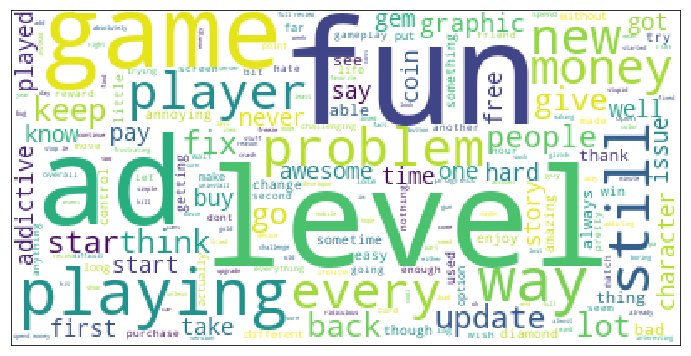

In [52]:
word_plot('GAME')

Both TOOLS and GAME  show 'ad' as a top-counted word. How does adding advertisement into these two kinds of apps influence their polarity?

In [53]:
# filter out all the reviews for GAME that contains 'ad'
review_game=review[review['Category']=='GAME']
game_po=review_game[review_game['Translated_Review'].map(lambda x :' ad ' in x)]
game_mean=game_po['Sentiment_Polarity'].mean()
print ('The average polarity of GAME reviews with ad is '+str(game_mean))

The average polarity of GAME reviews with ad is 0.028814102969561085


In [54]:
# filter out all the reviews for TOOLS that contains 'ad'
review_tools=review[review['Category']=='TOOLS']
tools_po=review_tools[review_tools['Translated_Review'].map(lambda x :' ad ' in x)]
tools_mean=tools_po['Sentiment_Polarity'].mean()
print ('The average polarity of TOOLS reviews with ad is '+str(tools_mean))

The average polarity of TOOLS reviews with ad is 0.21952777777777782


From the previous graph we see that avg polarity of TOOLS is 0.19, avg polarity of GAME is 0.05.

After we filter out all the reviews with 'ad', polarity from TOOLS increase a little bit, polarity from GAME decrease by 50%. We think that advertisement in TOOLS may help users find another app which is useful to users.But advertisement in GAME will disturb users from playing games. So there is a trade-off in GAME apps between earning advertisement profit with lower avg polarity(users not satisfied with the game)and recieving higher polarity(users satisfied with the game).

## Summary & Suggestions

From the analysis above, overall, we have some suggestions especially for app developers and companies:
* When developing a DATING or VIDEO_PLAYERS app, developers should concentrate on increasing stability and decreasing bugs in order to avoid getting low ratings because apps in these categories are easier to get low ratings.
* “Family”, “Game” and “Tools” are the most categories in the app store.
* Paid apps mostly cost 0.99 dollars, 3.02 dollars, 2 dollars or 5 dollars. Price less than 1 dollar will not significantly decrease the installs.
* The size of most of apps ranges from 4 to 30 MB, the installs will increase when the size goes up within this range, which indicates that the appearance of the app (which we assume is the reason for the increase of size) does matter.
* People tend to spend their money on games but when it comes to “Social Networking “and “Communication” they tend to install the free Apps on the Android Store.
* The 2 most installed Paid Apps are both games
* The majority of most installed free Apps lie in the Communication Category.
* The majority of most installed Paid Apps lie in the Gaming Category.
* Free apps have much more installs than paid apps, especially with teenagers. Paid app should target to mature adults
* There are some ridiculous apps in the app store which has an ridiculous high price with a name like “I’m rich”…
* “Photography” apps are doing well with a not that high market share compared with “Family” apps
* Most apps follow the trend: higher rating, higher sentiment polarity, except “Game” apps. The average rating for GAME is high but the average polarity is the least which means customers are not satisfied with GAME apps although they give GAME apps high rating. We guess that some games may give users some benefits or bonus in the game if users can give a 5-star rating even if customers are not satisfied with this game.
* According to the reviews of “Tools” apps, there’s a large potential demand for a useful alarm app with less error.
* If companies want to develop health and fitness apps,it is a good way to make effort on easy-to-use diet or exercise free apps to give users good impressions.
* If companies want to develop tools apps, some fast and simple alarm or calculator apps can help earn more market share.And also,some useful advertisement for users may also help leave good impressions to users.
* Both “Tools” apps and “Game” apps contains Ads in their app, but the average polarity of Game apps reviews are much more less than Tool apps reviews’, We think that advertisement in TOOLS may help users find another app which is useful to users.But advertisement in GAME will disturb users from playing games. So there is a trade-off in GAME apps between earning advertisement profit with lower avg polarity(users not satisfied with the game)and recieving higher polarity(users satisfied with the game).
* If companies want to develop game apps,the emphases should be the playing methods, the beauty of pictures and good stories in RPG games. 